1. Configuração do Ambiente
Primeiro, vamos configurar o ambiente no Google Colab, incluindo a importação das bibliotecas necessárias:

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt


2. Carregamento do Dataset
Vamos baixar e extrair o dataset de gatos e cachorros:


In [2]:
# Baixar o dataset Cats vs Dogs
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'  # Corrected URL
filename = 'cats_and_dogs.zip'
urllib.request.urlretrieve(url, filename)

# Extrair o dataset
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall() # Remove 'cats_and_dogs' to extract to current directory




3. Preparação dos Dados
Organizamos os dados em diretórios de treinamento e validação:

In [3]:
# --- Updated base_dir ---
base_dir = 'cats_and_dogs_filtered' # Corrected path
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Diretórios de treinamento
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Diretórios de validação
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


Geramos dados de treinamento e validação:

In [4]:
# Geração de dados de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Geração de dados de validação
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Nova seção

4. Criação do Modelo de Transfer Learning
Usamos a rede VGG16 pré-treinada, removendo as camadas de classificação e adicionando novas camadas:

In [5]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar a base convolucional
conv_base.trainable = False

# Adicionar novas camadas
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])


58889256/58889256 [==============================] - 4s 0us/step


5. Treinamento do Modelo
Treinamos o modelo com os dados de treinamento e validação:

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)


Epoch 1/30
100/100 [==============================] - 25s 181ms/step - loss: 0.7525 - accuracy: 0.7065 - val_loss: 0.4382 - val_accuracy: 0.8130
Epoch 2/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4796 - accuracy: 0.7730 - val_loss: 0.2992 - val_accuracy: 0.8610
Epoch 3/30
100/100 [==============================] - 18s 180ms/step - loss: 0.4243 - accuracy: 0.8070 - val_loss: 0.3197 - val_accuracy: 0.8470
Epoch 4/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4027 - accuracy: 0.8190 - val_loss: 0.2883 - val_accuracy: 0.8670
Epoch 5/30
100/100 [==============================] - 18s 181ms/step - loss: 0.3888 - accuracy: 0.8185 - val_loss: 0.3131 - val_accuracy: 0.8660
Epoch 6/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3488 - accuracy: 0.8475 - val_loss: 0.2612 - val_accuracy: 0.8870
Epoch 7/30
100/100 [==============================] - 18s 180ms/step - loss: 0.3476 - accuracy: 0.8450 - val_loss: 0.2764 - val_ac

6. Avaliação e Inferência
Avaliação do desempenho do modelo e visualização dos resultados:

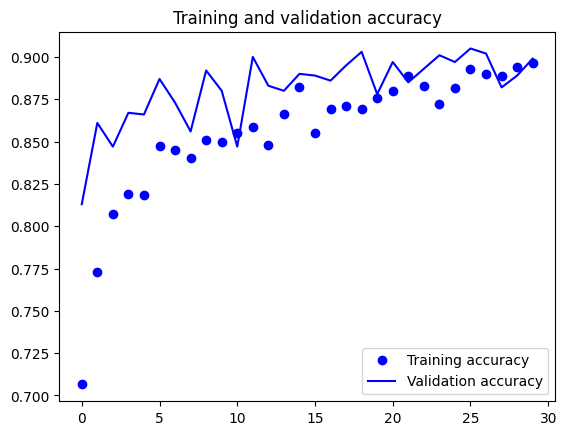

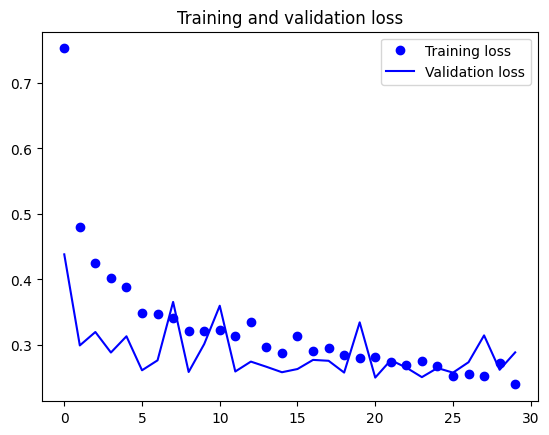

In [7]:
# Plotar os gráficos de precisão e perda
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
